# Topic Modeling and WordClouds on Beauty Reviews

This notebook focuses on topic modeling within a dataset of beauty reviews. It involves loading a dataset, applying a topic modeling technique (Latent Dirichlet Allocation), and saving the results. Additionally, word clouds are generated to visualize the most frequent terms in each topic.

## Libraries and Tools Used

- **Pandas:** Efficient data manipulation and handling.
- **WordCloud:** Used for generating word clouds.
- **Spacy:** Utilized for text preprocessing and lemmatization.
- **Scikit-Learn:** Leveraged for CountVectorizer and Latent Dirichlet Allocation.

## Workflow Overview

1. **Data Loading:** The beauty reviews dataset is loaded.
2. **Text Preprocessing:** Text is preprocessed using lemmatization.
3. **Topic Modeling (LDA):** Latent Dirichlet Allocation (LDA) is applied to identify topics in the reviews.
4. **WordCloud Generation:** Word clouds are generated for each topic to visualize the most frequent terms.
5. **Results Saving:** Save the results, including assigned topics, to a new CSV file.

Feel free to explore the code for a detailed understanding of the topic modeling process and the associated word clouds.

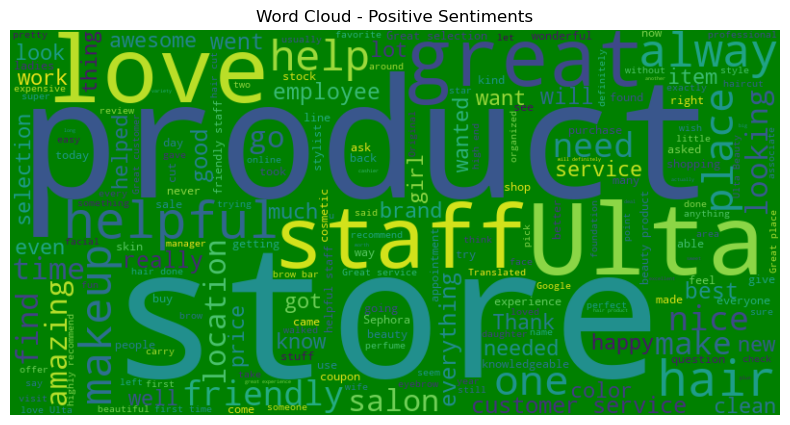

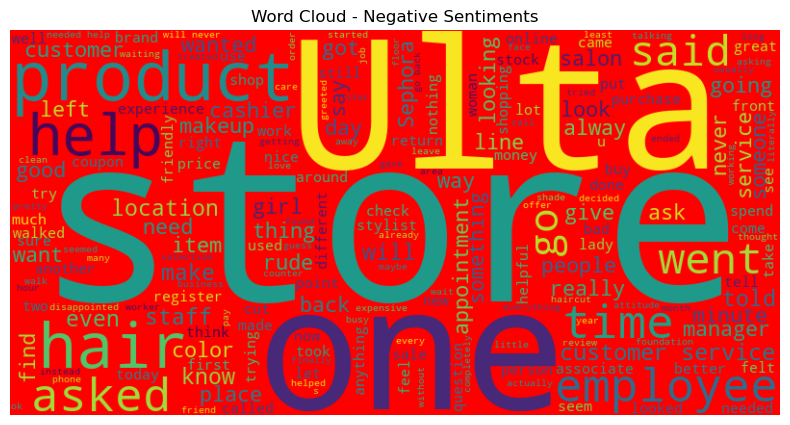

Positive Topic 1: hair, salon, ulta, cut, color, great, stylist, make, time, want
Positive Topic 2: help, product, ulta, store, need, look, make, makeup, time, ask
Positive Topic 3: love, brow, makeup, ulta, place, great, bar, product, good, eyebrow
Positive Topic 4: staff, helpful, great, store, friendly, love, product, clean, nice, ulta
Positive Topic 5: product, store, ulta, brand, beauty, makeup, great, like, love, hair
Negative Topic 1: help, store, like, look, ask, ulta, time, product, makeup, employee
Negative Topic 2: say, product, just, want, like, ulta, color, make, return, ask
Negative Topic 3: hair, cut, say, salon, appointment, tell, want, time, ask, color
Negative Topic 4: hair, salon, time, stylist, ulta, appointment, tell, just, look, pay
Negative Topic 5: store, ulta, customer, product, help, service, ask, employee, time, say


In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

ruta_csv = r'C:\Users\johan\Bootcamp_SoyHenry\PI_Final\sentiment_analysis.csv'
df = pd.read_csv(ruta_csv)


#This code creates word clouds to visually represent the most frequent words in positive 
#and negative sentiments from a dataset of text with sentiment labels.

# Generate WordCloud and DataFrames for positive and negative sentiments
def generate_wordcloud_and_dataframe(sentiment, background_color):
    reviews = df[df['sentiment'] == sentiment]['text']
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(' '.join(reviews))

    # Get the top 10 keywords
    keywords = list(wordcloud.words_.keys())[:10]

    # Create DataFrames to store reviews with positive and negative keywords
    reviews_with_positive_keywords = pd.DataFrame(columns=['Reseñas', 'Palabra Clave'])
    reviews_with_negative_keywords = pd.DataFrame(columns=['Reseñas', 'Palabra Clave'])

    for keyword in keywords:
        reviews_with_keyword = reviews[reviews.str.contains(keyword, case=False)]
        
        if sentiment == 1:
            df_keyword = pd.DataFrame({'Reseñas': reviews_with_keyword, 'Palabra Clave': keyword})
            reviews_with_positive_keywords = pd.concat([reviews_with_positive_keywords, df_keyword], ignore_index=True)
        else:
            df_keyword = pd.DataFrame({'Reseñas': reviews_with_keyword, 'Palabra Clave': keyword})
            reviews_with_negative_keywords = pd.concat([reviews_with_negative_keywords, df_keyword], ignore_index=True)

    return wordcloud, reviews_with_positive_keywords, reviews_with_negative_keywords

# Generate WordCloud and DataFrames for negative sentiment
wordcloud_negative, _, reviews_negative = generate_wordcloud_and_dataframe(0, 'red')

# Generate WordCloud and DataFrames for positive sentiment
wordcloud_positive, reviews_positive, _ = generate_wordcloud_and_dataframe(1, 'green')

# Plot and display the WordClouds
def plot_wordcloud(wordcloud, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wordcloud(wordcloud_positive, 'Word Cloud - Positive Sentiments')
plot_wordcloud(wordcloud_negative, 'Word Cloud - Negative Sentiments')

# Display DataFrames with reviews containing positive and negative keywords
#print("Reviews with Positive Keywords:")
#print(reviews_positive)
#reviews_positive
#print("\nReviews with Negative Keywords:")
#print(reviews_negative)

# Load DataFrames with positive and negative reviews
df_positive = reviews_positive
df_negative = reviews_negative

# Load the spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize and preprocess the text
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join(token.lemma_ for token in doc if token.is_alpha)
    return lemmatized_text

# Apply preprocessing to the text of positive reviews
df_positive['Processed Text'] = df_positive['Reseñas'].apply(preprocess_text)

# Apply preprocessing to the text of negative reviews
df_negative['Processed Text'] = df_negative['Reseñas'].apply(preprocess_text)

# Create a vector representation of the text using CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# Apply LDA model to positive reviews
X_positive = vectorizer.fit_transform(df_positive['Processed Text'])
lda_positive = LatentDirichletAllocation(n_components=5, random_state=42)
lda_positive.fit(X_positive)

# Show topics and associated keywords for positive reviews
feature_names_positive = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_positive.components_):
    top_keywords_idx = topic.argsort()[:-10 - 1:-1]
    top_keywords = [feature_names_positive[i] for i in top_keywords_idx]
    print(f'Positive Topic {topic_idx + 1}: {", ".join(top_keywords)}')

# Apply LDA model to negative reviews
X_negative = vectorizer.fit_transform(df_negative['Processed Text'])
lda_negative = LatentDirichletAllocation(n_components=5, random_state=42)
lda_negative.fit(X_negative)

# Show topics and associated keywords for negative reviews
feature_names_negative = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_negative.components_):
    top_keywords_idx = topic.argsort()[:-10 - 1:-1]
    top_keywords = [feature_names_negative[i] for i in top_keywords_idx]
    print(f'Negative Topic {topic_idx + 1}: {", ".join(top_keywords)}')

# Assign a topic to each positive review
df_positive['Assigned Topic'] = lda_positive.transform(X_positive).argmax(axis=1)

# Assign a topic to each negative review
df_negative['Assigned Topic'] = lda_negative.transform(X_negative).argmax(axis=1)

# Save DataFrames with assigned topics to new CSV files
df_positive.to_csv('reviews_with_topics_positive.csv', index=False)
df_negative.to_csv('reviews_with_topics_negative.csv', index=False)


___________________________________________________________________________________________________________________

### 

For a better interpretation of the themes based on the keywords associated with each theme that the model has provided us, we recommend applying a more advanced language model such as GPT-3 from OpenAI (it is not free and requires access through the API from OpenAI).

OpenAI Prompt

Suggest possible themes for these topics:
Positive Topic 1: hair, salon, ulta, cut, color, great, stylist, make, time, want<br /> 
Positive Topic 2: help, product, ulta, store, need, look, make, makeup, time, ask<br /> 
Positive Topic 3: love, brow, makeup, ulta, place, great, bar, product, good, eyebrow<br /> 
Positive Topic 4: staff, helpful, great, store, friendly, love, product, clean, nice, ulta<br /> 
Positive Topic 5: product, store, ulta, brand, beauty, makeup, great, like, love, hair<br /> 
Negative Topic 1: help, store, like, look, ask, ulta, time, product, makeup, employee<br /> 
Negative Topic 2: say, product, just, want, like, ulta, color, make, return, ask<br /> 
Negative Topic 3: hair, cut, say, salon, appointment, tell, want, time, ask, color<br /> 
Negative Topic 4: hair, salon, time, stylist, ulta, appointment, tell, just, look, pay<br /> 
Negative Topic 5: store, ulta, customer, product, help, service, ask, employee, time, say<br /> 

Sure, based on the keywords associated with each topic, here are possible thematic interpretations:
* Positive Topics:
    - Topic 1: Hair Salon Experience
    Keywords: hair, salon, ulta, cut, color, great, stylist, make, time, want
    Possible Theme: Positive experiences related to hair salon services at Ulta, including cuts, colors, and stylist interactions.

    - Topic 2: Store Assistance and Product Advice
    Keywords: help, product, ulta, store, need, look, make, makeup, time, ask
    Possible Theme: Positive interactions with store staff, seeking product advice, and overall helpful assistance at Ulta.
    
    - Topic 3: Love for Makeup and Brow Services
    Keywords: love, brow, makeup, ulta, place, great, bar, product, good, eyebrow
    Possible Theme: Positive sentiments towards makeup products, brow services, and overall satisfaction with Ulta's offerings.

    - Topic 4: Positive Store Environment and Staff
    Keywords: staff, helpful, great, store, friendly, love, product, clean, nice, ulta
    Possible Theme: Positive experiences related to the store environment, helpful staff, and overall positive impressions of Ulta.

    - Topic 5: Appreciation for Beauty Products
    Keywords: product, store, ulta, brand, beauty, makeup, great, like, love, hair
    Possible Theme: Positive sentiments towards various beauty products, brands, and the overall selection at Ulta.

* Negative Topics:
    - Topic 1: Challenges with Store Assistance
    Keywords: help, store, like, look, ask, ulta, time, product, makeup, employee
    Possible Theme: Challenges or negative experiences related to seeking assistance, store interactions, and employee support.
    
    - Topic 2: Dissatisfaction or Issues with Products
    Keywords: say, product, just, want, like, ulta, color, make, return, ask
    Possible Theme: Dissatisfaction or issues related to specific products, color choices, and product returns at Ulta.
    
    - Topic 3: Challenges with Hair Salon Services
    Keywords: hair, cut, say, salon, appointment, tell, want, time, ask, color
    Possible Theme: Challenges or negative experiences related to hair salon services, including appointments, cuts, and color treatments.
    
    - Topic 4: Negative Salon Experiences
    Keywords: hair, salon, time, stylist, ulta, appointment, tell, just, look, pay
    Possible Theme: Negative experiences related to the hair salon, including stylist interactions, appointment issues, and overall dissatisfaction.
    
    - Topic 5: Customer Service and Assistance Concerns
    Keywords: store, ulta, customer, product, help, service, ask, employee, time, say
    Possible Theme: Concerns or dissatisfaction related to customer service, assistance, and employee interactions at Ulta.

These thematic interpretations are based on the keywords associated with each topic. It's important to note that the actual interpretation may vary based on the context of the reviews and the specific sentiments expressed by customers.